In [57]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Train own embedding using doc2vec from gensim

In [58]:
df = pd.read_csv('../data/euroleaks/cleaned.csv')
df.head()

,speaker,speech,timestamp,date
0,jeroen dijsselbloem,… of your responses or questions. and can i fi...,1900-01-01 00:00:00,2015-02-24 00:00:00
1,speaker 2,"uh, yes, uh, thank you, jeroen. well, uh, comm...",1900-01-01 00:00:10,2015-02-24 00:00:00
2,michael noonan,michael noonan.,1900-01-01 00:01:27,2015-02-24 00:00:00
3,speaker 2,"uh, it is therefore regrettable that, uh-",1900-01-01 00:01:29,2015-02-24 00:00:00
4,speaker 2,"… that the letter by the minister does not, uh...",1900-01-01 00:01:37,2015-02-24 00:00:00


In [59]:
# see examples of cleaned speech
#for s in df.speech[:5]:
#    print(s.strip(), '\n')

### stopwords

In [60]:
import json
import re

with open('../data/euroleaks/amend_names.json', 'r') as f:
    amend_names = json.load(f)
    
# make stopwords out of names
stopnames = []

for names in amend_names.values():
    for name in names:
        if not re.search('\[.*\]', name):
            stopnames += name.split(' ')
            
for name in df.speaker.unique():
    if 'speaker' not in name:
        stopnames += name.split(' ')

stopnames = set(stopnames)
        
stopnames.remove('greek')
stopnames.remove('representative')
stopnames.remove('de')
stopnames.remove('van')

context_stopwords = set([
    'erm', # synonym for hmm in https://euroleaks.diem25.org/leaks/mar17ewg/
#    'today',
#    'tomorrow',
#    'yesterday',
#    'day',
#    'week',
#    'month'
])

In [61]:
#stopnames

### collocations

In [62]:
def apply_trigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2,b3 in set_colloc:
        res = res.replace(f'{b1} {b2} {b3}', f'{b1}_{b2}_{b3}')
    return res

def apply_bigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2 in set_colloc:
        res = res.replace(f'{b1} {b2}', f'{b1}_{b2}')
    return res

trigram_colloc = {('euro', 'working', 'group')}

bigram_colloc = {
    ('20th', 'february'),
    ('aide', 'memoire'),
    ('anti', 'corruption'),
    ('brussel', 'group'),
    ('capital', 'control'),
    ('central', 'bank'),
    ('collective', 'bargaining'),
    ('common', 'ground'),
    ('debt', 'sustainability'),
    ('govern', 'council'),
    ('growth', 'friendly'),
    ('interest', 'rate'),
    ('labor', 'market'),
    ('maximum', 'flexibility'),
    ('member', 'state'),
    ('minimum', 'wage'),
    ('primary', 'surplus'),
    ('prime', 'minister'),
    ('prior', 'action'),
    ('product', 'market'),
    ('second', 'letter'),
    ('smp', 'bond'),
    ('structural', 'reform'),
    ('successful', 'conclusion'),
    ('technical', 'team'),
    ('real', 'estate')
}

### quantify how much each speaker spoke

In [209]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english') # does tokenozation under the hood
X = vectorizer.fit_transform(df.speech)

df['wordcount'] = X.toarray().sum(axis=1)
wc_by_speaker = df.groupby('speaker')['wordcount'].sum()

In [210]:
X.shape

(1492, 4644)

In [211]:
wc_by_speaker.describe()

count       61.000000
mean       615.147541
std       1550.831840
min          2.000000
25%         62.000000
50%        155.000000
75%        609.000000
max      10270.000000
Name: wordcount, dtype: float64

In [212]:
wc_threshold = 200

insignificant_speakers = wc_by_speaker.index[wc_by_speaker < 200].to_numpy()

In [213]:
words = np.array(vectorizer.get_feature_names())
counts = X.toarray().sum(axis=0)

sort_ix = np.argsort(counts)[::-1] # descendingly
words = words[sort_ix]
counts = counts[sort_ix]

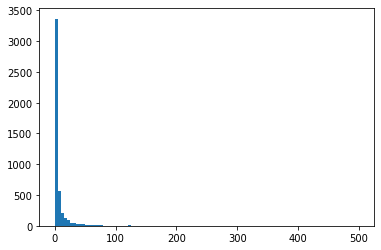

In [222]:
# histogram of word frequency without english stopwords
_ = plt.hist(counts, bins=100, range=(0,500))

Zipf's law?

Try with mean document frequency. What about TFIDF?

In [272]:
words = np.array(vectorizer.get_feature_names())
freqs = np.mean(X.toarray() > 0, axis=0)

sort_ix = np.argsort(freqs)[::-1] # descendingly
words = words[sort_ix]
freqs = freqs[sort_ix]

In [273]:
words[:100]

array(['uh', 'um', 'think', 'institutions', 'greek', 'thank',
       'government', 'agreement', 'just', 'said', 'let', 'say', 'point',
       'know', 'need', 'like', 'greece', 'time', 'going', 'jeroen',
       'process', 'question', 'colleagues', 'program', 'don', 'work',
       'course', 'make', 'come', 'way', 'eurogroup', 'authorities',
       'meeting', 'situation', 'today', 'clear', 'want', 'proposal',
       'new', 'people', 'yes', 'yanis', 'second', 'agree', 'measures',
       've', 'quite', 'proposals', 'right', 'reforms', 'list', 'ask',
       'fiscal', 'terms', 'important', 'discussion', 'really', 'euro',
       'agreed', 'end', 'review', 'days', 'group', 'possible', 'believe',
       'months', 'fully', 'progress', 'view', 'debt', 'number', 'order',
       'table', 'political', 'given', 'mentioned', 'referendum', 'issues',
       'forward', 'needs', 'discussions', 'far', 'understand', 'having',
       'different', 'll', 'okay', 'liquidity', 'reform', 'pierre',
       'technica

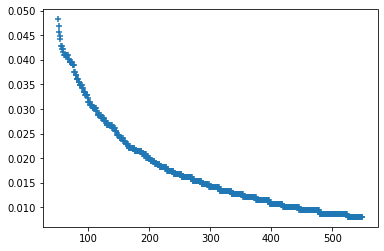

In [278]:
plt.scatter(range(50,550), freqs[50:550], marker='+')

In [281]:
pd.Series(freqs).describe(percentiles=[.5, .75, .9, .95, .99])

count    4644.000000
mean        0.004427
std         0.013231
min         0.000670
50%         0.001340
75%         0.003351
90%         0.009383
95%         0.017426
99%         0.052949
max         0.458445
dtype: float64

In [283]:
np.sum(freqs > 0.017426)

240

### tokenize, lemmatize, remove stopwords, apply collocations
- https://radimrehurek.com/gensim/models/doc2vec.html
- https://radimrehurek.com/gensim/models/doc2vec.html#gensim.models.doc2vec.TaggedDocument

In [63]:
import spacy

nlp = spacy.load('en_core_web_sm')  # speed
#nlp = spacy.load('en_core_web_trf') # accuracy, change to this later

In [64]:
def filter_token(token):
    return token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}\
        and not token.is_stop\
        and not token.text in stopnames\
        and not token.text in context_stopwords\
        and len(token.text) > 1

#def filter_token(token):
#    return token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}\
#        and len(token.text) > 1

In [65]:
grouped = df.drop(columns=['timestamp','date']).groupby('speaker').apply(lambda s: ' '.join(s.speech))

In [66]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

t = time.time()

documents = []
for speaker, text in grouped.iteritems():
    
    doc = nlp(text)
    
    doc_ = [token.lemma_ for sentence in doc.sents for token in sentence
                if filter_token(token)
            ]
    
    # apply collocations
    doc_ = apply_bigram_colloc(apply_trigram_colloc(' '.join(doc_), trigram_colloc), bigram_colloc).split()
    
    # maybe add date to tags, or country/intitution?
    # TaggedDocument takes list of words as input
    documents.append(TaggedDocument(doc_, tags=[speaker]))
    
print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 0.96 mins


In [67]:
print(f'There are {len(documents)} documents (=speakers).')

There are 61 documents (=speakers).


#### get sentence length statistics

In [17]:
t = time.time()

doc = nlp(' '.join(df.speech))

sentences = [[token.lemma_ for token in sentence
                if filter_token(token)
              ] for sentence in doc.sents
            ]

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 2.25 mins


In [18]:
# apply collocations
sentences = [apply_bigram_colloc(apply_trigram_colloc(' '.join(s), trigram_colloc), bigram_colloc).split() for s in sentences]

In [19]:
# number of words in a sentence statistics
len_sentences = [len(sent) for sent in sentences]
pd.Series(len_sentences).describe()

count    4547.000000
mean        6.808885
std         6.219248
min         0.000000
25%         2.000000
50%         5.000000
75%        10.000000
max        57.000000
dtype: float64

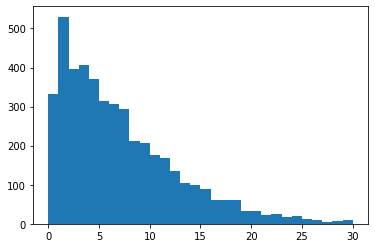

In [20]:
_ = plt.hist(len_sentences, bins=range(31), range=(0,30))

#### get speech length statistics

In [21]:
# join speech of consecutive rows with same speaker

df_squeezed = pd.DataFrame(columns=['speaker','speech','date'])

previous_speaker = None
speech = None
previous_date = None

for index, data in df.iterrows():
    
    if not previous_speaker and not speech and not previous_date:
        previous_speaker = data.speaker
        speech = data.speech
        previous_date = data.date
    elif data.speaker == previous_speaker and previous_date == data.date:
        speech = ' '.join((speech, data.speech))
    else:
        df_squeezed.loc[len(df_squeezed.index)] = [
            previous_speaker,
            speech,
            previous_date
        ]
        previous_speaker = data.speaker
        speech = data.speech
        previous_date = data.date

In [22]:
t = time.time()

docs = [
    ' '.join([token.lemma_ for sentence in nlp(doc).sents for token in sentence
              if filter_token(token)
             ])
             for doc in df_squeezed.speech.to_numpy()
]

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 1.04 mins


In [23]:
speeches = [' '.join(sentences).split() for sentences in docs]

In [24]:
# number of words in a speech statistics
len_speeches = [len(speech) for speech in speeches]
pd.Series(len_sentences).describe()

count    4547.000000
mean        6.808885
std         6.219248
min         0.000000
25%         2.000000
50%         5.000000
75%        10.000000
max        57.000000
dtype: float64

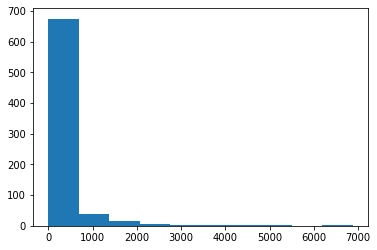

In [25]:
_ = plt.hist(len_speeches)

### Doc2Vec

In [134]:
d2v_model = Doc2Vec(vector_size=300,
                    window=3,
                    sample=1e-5,
                    negative=20, # usually 5-20
                    min_count=10,
                    #alpha=0.03,
                    #min_alpha=0.000007,
                    workers=-1,
                    epochs=10000,
                    dm=0,
                    dbow_words=1
)

In [135]:
print(f'There are {np.sum([len(d.words) for d in documents])} total words.')

There are 30965 total words.


**Is this enough for the word embedding to capture word relations?**

In [136]:
d2v_model.build_vocab(documents)

In [137]:
t = time.time()

d2v_model.train(documents, 
                total_examples=d2v_model.corpus_count, 
                epochs=100)#d2v_model.epochs)

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 0.0 mins


In [138]:
keywords = [
    'greece',
    'institution',
    'imf',
    'ecb',
    'commission',
    'government',
    'referendum',
    'mou',
    'debt',
    'debt_sustainability',
    'pension',
    'bank',
    'bond',
    'crisis'
]

df_closest = pd.DataFrame({word.split('_')[0]: [n.split('_')[0] for n,score in d2v_model.wv.most_similar(word)] for word in keywords})
df_closest

,greece,institution,imf,ecb,commission,government,referendum,mou,debt,pension,bank,bond,crisis
0,debate,sla,round,debt,past,primary,look,suggestion,run,line,possibly,conference,govern
1,backtracking,cut,primary,hard,procedure,team,ahead,development,discussion,doubt,early,communication,extend
2,implication,document,backtracking,policy,short,debt,negotiate,pretty,european,implement,away,undertake,low
3,particular,wrong,significant,face,feeling,one,implication,debate,government,market,difficult,second,inform
4,share,country,raise,move,meeting,base,room,politically,exactly,payment,ecb,outcome,comment
5,express,reaction,detail,bank,environment,perspective,hard,real,helpful,want,pass,point,go
6,extension,hear,improve,recommendation,refer,secondly,economy,half,ago,regard,question,measure,accept
7,institution,detailed,crisis,analysis,appear,good,leader,party,hear,add,see,expire,imf
8,stage,circumstance,listen,major,brussel,collect,technical,separate,instead,speed,monetary,sign,prime
9,proceed,place,completely,difficult,exactly,short,hour,cover,reduction,country,conference,ahead,happen


In [139]:
d2v_model.docvecs.most_similar('yanis varoufakis', topn=10)

[('speaker 4', 0.12930405139923096),
 ('kian', 0.08553998172283173),
 ('jeroen dijsselbloem', 0.08080030977725983),
 ('poul mathias thomsen', 0.0626433715224266),
 ('greek representative', 0.05928734689950943),
 ('alexander stubb', 0.05550258979201317),
 ('pierre moscovici', 0.04928017035126686),
 ('martin', 0.04772745445370674),
 ('luis pierre', 0.04753771051764488),
 ('irina', 0.04052360728383064)]

In [140]:
d2v_model.docvecs['yanis varoufakis'].shape

(300,)

In [141]:
dvecs = {}
for speaker in np.unique(df.speaker):
    if speaker not in insignificant_speakers:
        dvecs[speaker] = d2v_model.docvecs[speaker]
        #print(speaker)

In [142]:
X = pd.DataFrame(dvecs).to_numpy().T

### PCA

In [143]:
# center and rescale
X = (X - X.mean(axis=0)) / X.std(axis=0)

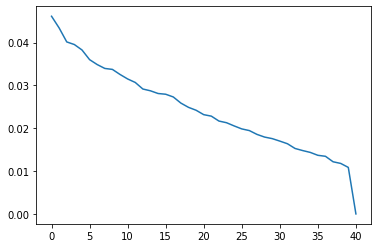

In [144]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit_transform(X)

plt.plot(pca.explained_variance_ratio_)

In [145]:
np.sum(pca.explained_variance_ratio_[:30])

0.8601911

In [147]:
X_reduced = pca.components_[:,:41]
X_reduced.shape

(41, 41)

### agglomerative clustering

In [148]:
from sklearn.cluster import AgglomerativeClustering

number_of_clusters = 5

agg = AgglomerativeClustering(n_clusters=number_of_clusters) # Ward linkage by default
clusters = agg.fit_predict(X_reduced)

In [149]:
clusters

array([2, 0, 1, 1, 4, 4, 0, 0, 1, 1, 1, 1, 1, 2, 0, 4, 1, 2, 1, 2, 2, 1,
       1, 0, 0, 2, 1, 4, 0, 0, 1, 2, 4, 2, 4, 2, 1, 2, 0, 2, 3])

In [150]:
for k in range(number_of_clusters):
    print(f'cluster {k}:')
    for speaker in np.array(list(dvecs.keys()))[clusters==k]:
        print(f'\t{speaker}')
    print()

cluster 0:
	benoît cœuré
	harris georgiades
	jeroen dijsselbloem
	maria luís albuquerque
	rimantas šadžius
	speaker
	speaker 2
	speaker 21
	translator

cluster 1:
	christine lagarde
	declan costello
	klaus regling
	luca antonio ricci
	luis de guindos
	luis pierre
	male
	michael noonan
	nikos theocarakis
	pierre moscovici
	poul mathias thomsen
	speaker 12
	speaker 3
	thomas wieser

cluster 2:
	alexander stubb
	marco buti
	michel sapin
	peter kažimír
	pier carlo padoan
	speaker 1
	speaker 5
	speaker 7
	thomas steffen
	tooma
	wolfgang schäuble

cluster 3:
	yanis varoufakis

cluster 4:
	edward scicluna
	hans jörg schelling
	mario draghi
	speaker 19
	speaker 6
	speaker 8



# Pretrained embeddings

- https://kavita-ganesan.com/easily-access-pre-trained-word-embeddings-with-gensim/

In [68]:
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

In [78]:
t = time.time()

# download the model and return as object ready for use
#model = api.load("word2vec-google-news-300")
model = api.load("glove-wiki-gigaword-100")
#model = api.load("glove-twitter-25")

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 1.08 mins


In [115]:
model.most_similar("greece",topn=10)

[('bulgaria', 0.7619102001190186),
 ('latvia', 0.7298097610473633),
 ('estonia', 0.7295340299606323),
 ('portugal', 0.7255569696426392),
 ('hungary', 0.724166214466095),
 ('italy', 0.7235244512557983),
 ('macedonia', 0.7231630086898804),
 ('albania', 0.7162705063819885),
 ('turkey', 0.7141141295433044),
 ('iceland', 0.7076017260551453)]

In [116]:
model.most_similar("eurogroup",topn=10)

[('juncker', 0.6745191812515259),
 ('ecofin', 0.5150660276412964),
 ('claude', 0.5108284950256348),
 ('arthuis', 0.49629801511764526),
 ('maystadt', 0.4791005551815033),
 ('56-member', 0.4776451587677002),
 ('g-7', 0.4750973880290985),
 ('mersch', 0.46765682101249695),
 ('g7', 0.4653204381465912),
 ('ecb', 0.46386680006980896)]

In [117]:
type(model)

gensim.models.keyedvectors.Word2VecKeyedVectors

In [118]:
model.__contains__('interest rate')

False

In [151]:
dvecs = {
    d.tags[0]: np.mean([model[word] for word in d.words if model.__contains__(word)], axis=0)
    for d in documents if d.tags[0] not in insignificant_speakers
}

In [152]:
X = pd.DataFrame(dvecs).to_numpy().T

In [153]:
X.shape

(41, 100)

In [156]:
from sklearn.cluster import AgglomerativeClustering

number_of_clusters = 5

agg = AgglomerativeClustering(n_clusters=number_of_clusters) # Ward linkage by default
clusters = agg.fit_predict(X)

In [157]:
for k in range(number_of_clusters):
    print(f'cluster {k}:')
    for speaker in np.array(list(dvecs.keys()))[clusters==k]:
        #if 'speaker' not in speaker:
        print(f'\t{speaker}')
    print()

cluster 0:
	benoît cœuré
	declan costello
	klaus regling
	luca antonio ricci
	luis pierre
	marco buti
	mario draghi
	nikos theocarakis
	poul mathias thomsen
	speaker 1
	speaker 2
	speaker 3
	speaker 6
	yanis varoufakis

cluster 1:
	harris georgiades
	peter kažimír
	pier carlo padoan
	rimantas šadžius
	speaker
	speaker 21
	tooma

cluster 2:
	michel sapin

cluster 3:
	alexander stubb
	edward scicluna
	hans jörg schelling
	luis de guindos
	maria luís albuquerque
	speaker 12
	speaker 7
	speaker 8

cluster 4:
	christine lagarde
	jeroen dijsselbloem
	male
	michael noonan
	pierre moscovici
	speaker 19
	speaker 5
	thomas steffen
	thomas wieser
	translator
	wolfgang schäuble



In [81]:
model_ = api.load("glove-twitter-25")

In [83]:
model_.most_similar("eurogroup",topn=20)

[('титул', 0.8404937386512756),
 ('заводской', 0.8266498446464539),
 ('дивизион', 0.8172610998153687),
 ('окружной', 0.8143825531005859),
 ('ανακοίνωσε', 0.8123123645782471),
 ('insolvenz', 0.8114680051803589),
 ('verklagt', 0.8110349178314209),
 ('rté', 0.807128369808197),
 ('argentinien', 0.8036397695541382),
 ('эрудит', 0.7994272708892822),
 ('тайфун', 0.793281078338623),
 ('превратила', 0.7902624607086182),
 ('промоутер', 0.7893069982528687),
 ('познание', 0.7892136573791504),
 ('окр', 0.7884601354598999),
 ('абсолютный', 0.7867385149002075),
 ('рейтингу', 0.78517746925354),
 ('аиф', 0.7848348617553711),
 ('муниципальный', 0.7845935821533203),
 ('ibnlive', 0.7843928933143616)]

So according to this embedding, mostly Russians and Germans tweeted about the Eurogroup. rté is Irish National Television.